# Projekt Week 03 - Bike Share Demand

## Buisness Goal

#### Predict the total count of bikes rented during each hour 

## Import

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (15, 8)

## Read Data

In [6]:
data = pd.read_csv('data/bike-share-demand/train.csv', parse_dates=True, index_col=0)

In [7]:
data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
data.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


* *datetime* - hourly date + timestamp  
* *season* -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* *holiday* - whether the day is considered a holiday
* *workingday* - whether the day is neither a weekend nor holiday
* *weather* 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* *temp* - temperature in Celsius
* *atemp* - "feels like" temperature in Celsius
* *humidity* - relative humidity
* *windspeed* - wind speed
* *casual* - number of non-registered user rentals initiated
* *registered* - number of registered user rentals initiated
* *count* - number of total rentals **(y value)**

In [9]:
### y-value = 'count' column

## Train-Test-Split

#### Test data is in seperate file test.csv 

## EDA

In [10]:
# extract date features
def extract_date_info(df):
    
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['weekday'] = df.index.day_name()
    df['hour'] = df.index.hour

In [11]:
# Outlier detection

# https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm
def m_z_score(series):
    z_score = (0.6745*(series-series.median()))/series.mad()
    return z_score

def detect_outlier(series, threshold=3.5):
    outliers = series[m_z_score(series) > threshold]
    return outliers

In [12]:
data_EDA = data.copy()

In [13]:
data_EDA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [14]:
data_EDA.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


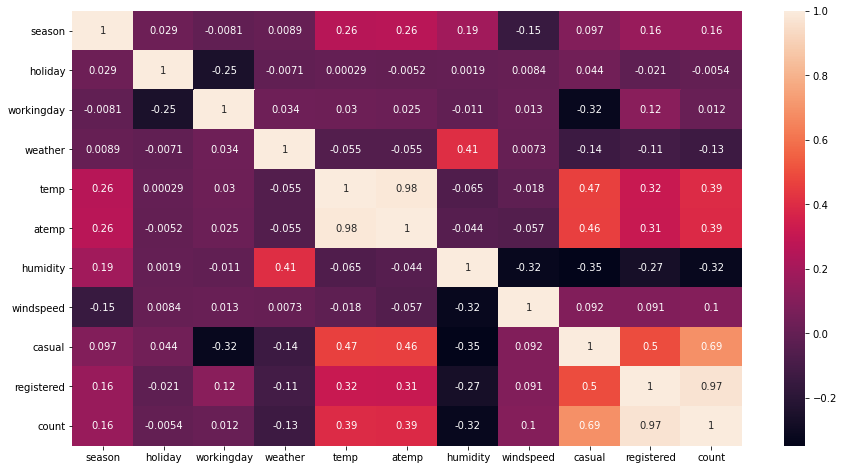

In [15]:
sns.heatmap(data_EDA.corr(), annot=True)

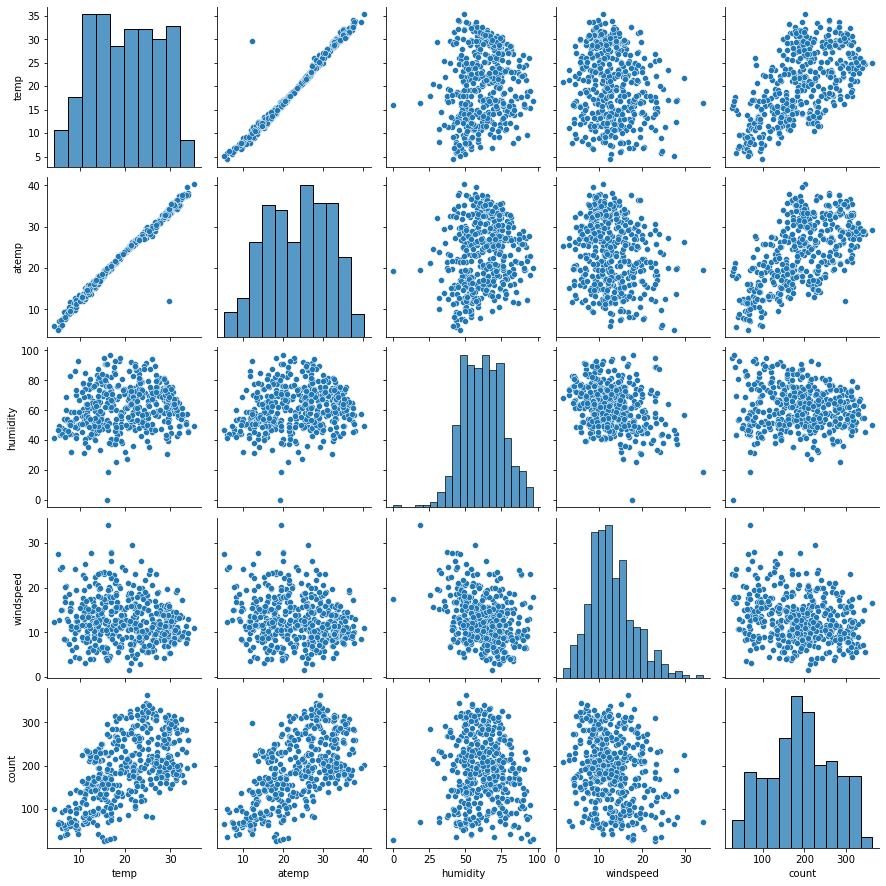

In [16]:
sns.pairplot(data= data_EDA[['temp', 'atemp', 'humidity', 'windspeed', 'count']].resample('D').mean())

In [17]:
extract_date_info(data_EDA)

In [18]:
data_EDA.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,weekday,hour
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,Saturday,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,Saturday,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,Saturday,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,1,Saturday,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,1,Saturday,4


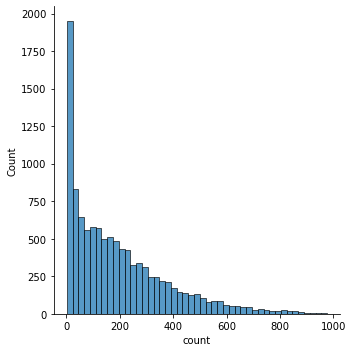

In [19]:
sns.displot(data_EDA['count'])

/Users/marf/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


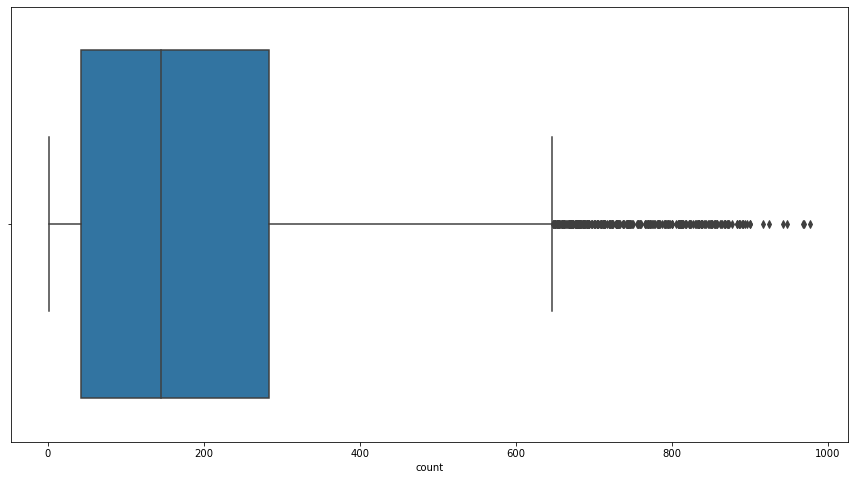

In [20]:
sns.boxplot(data_EDA['count'])

## Detect outliers

In [21]:
detect_outlier(data_EDA['count'])

datetime
2012-08-01 18:00:00    891
2012-08-16 17:00:00    897
2012-09-10 18:00:00    968
2012-09-11 17:00:00    970
2012-09-12 17:00:00    925
2012-09-12 18:00:00    977
2012-09-14 17:00:00    894
2012-09-19 17:00:00    886
2012-09-19 18:00:00    892
2012-10-03 17:00:00    917
2012-10-04 17:00:00    901
2012-10-04 18:00:00    887
2012-10-05 17:00:00    900
2012-10-10 17:00:00    948
2012-10-16 17:00:00    943
2012-10-17 17:00:00    888
2012-10-18 17:00:00    890
Name: count, dtype: int64

In [22]:
for column in data_EDA.columns:
    if data_EDA[column].dtype == float:
            print(detect_outlier(data_EDA[column]))
    else:
        None

Series([], Name: temp, dtype: float64)
Series([], Name: atemp, dtype: float64)
datetime
2011-02-15 01:00:00    51.9987
2011-02-19 15:00:00    50.0021
2011-07-03 17:00:00    56.9969
2011-07-03 18:00:00    56.9969
2012-02-12 04:00:00    47.9988
2012-04-09 12:00:00    47.9988
Name: windspeed, dtype: float64


## Transformation of Target

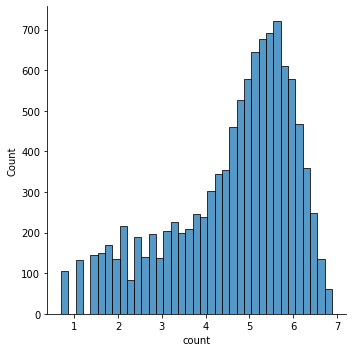

In [23]:
sns.displot(np.log1p(data_EDA['count']))

<ipython-input-24-82e721750ae8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_EDA.groupby('season')['casual', 'registered'].mean().plot(kind='bar')


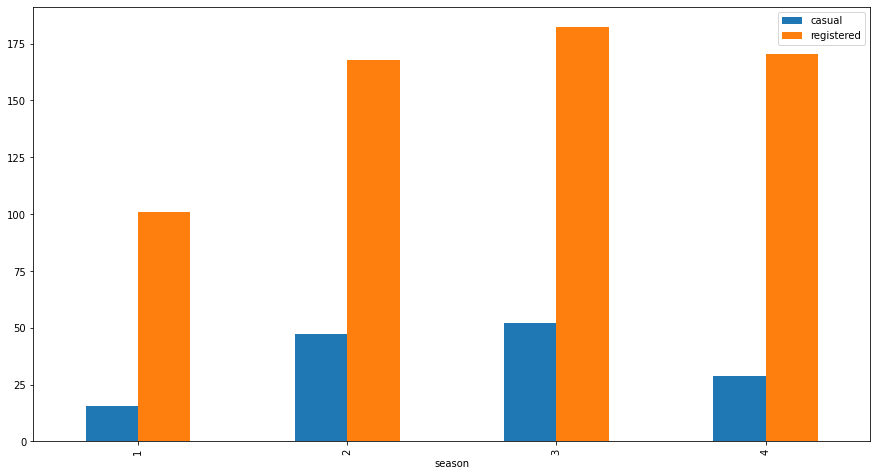

In [24]:
data_EDA.groupby('season')['casual', 'registered'].mean().plot(kind='bar')

<ipython-input-25-acd05de324ea>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_EDA.groupby('hour')['casual', 'registered'].mean().plot(kind='bar')


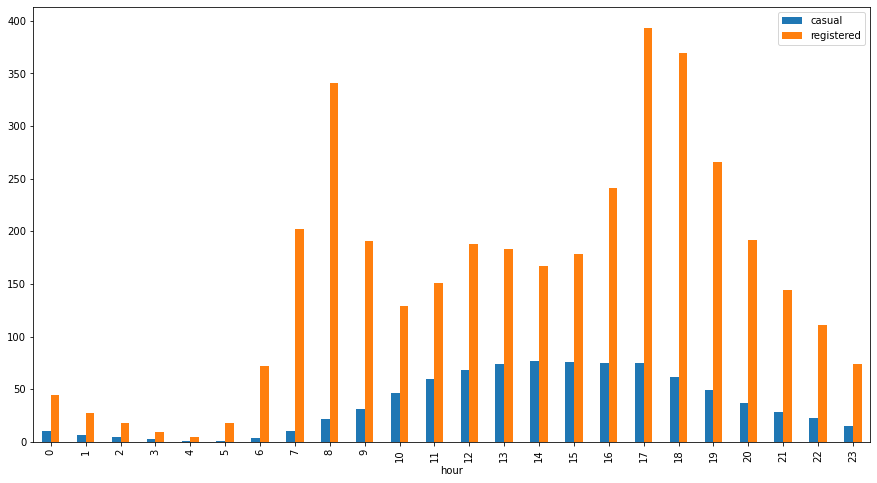

In [25]:
data_EDA.groupby('hour')['casual', 'registered'].mean().plot(kind='bar')

<ipython-input-26-6b4eaad822a7>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_EDA.groupby('weekday')['casual', 'registered'].mean().plot(kind='bar')


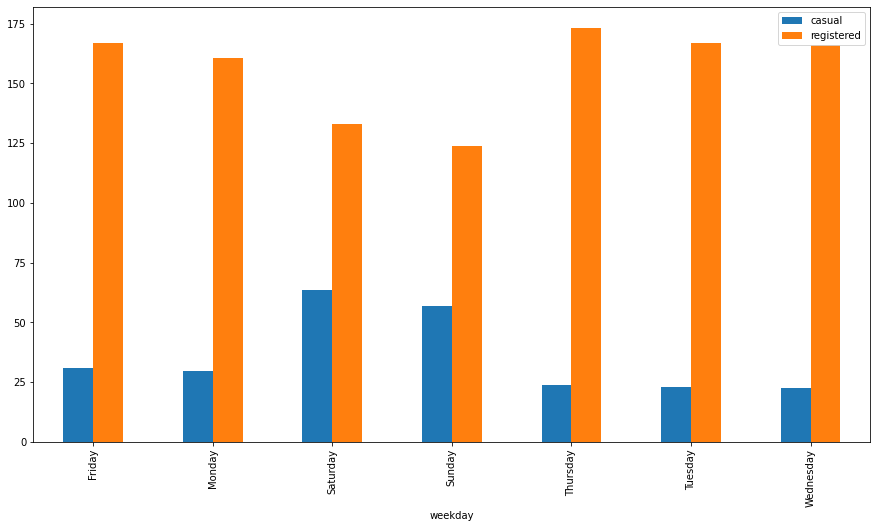

In [26]:
data_EDA.groupby('weekday')['casual', 'registered'].mean().plot(kind='bar')

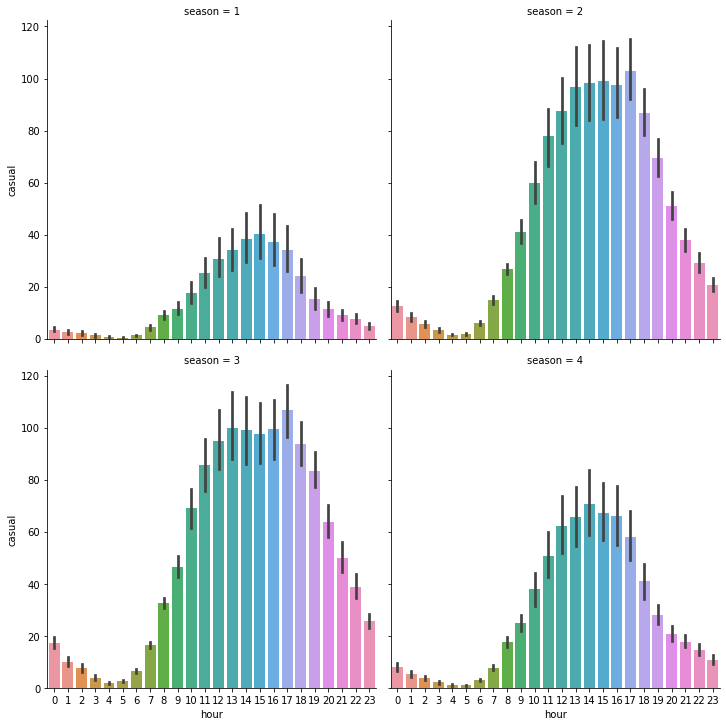

In [27]:
sns.catplot(x='hour', y='casual', data=data_EDA, col='season', col_wrap=2, kind='bar')
#sns.relplot(x='hour', y='registered', data=X_train, row='season')

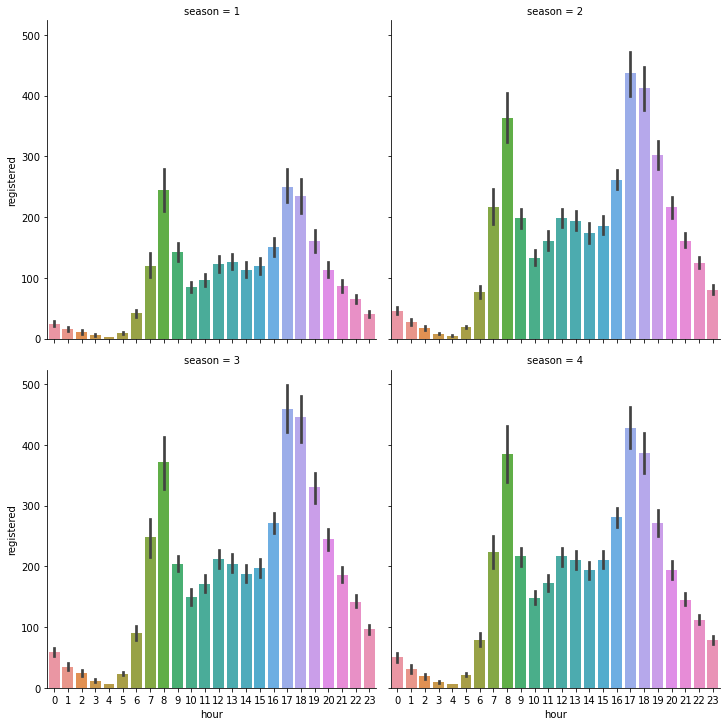

In [28]:
sns.catplot(x='hour', y='registered', data=data_EDA, col='season', col_wrap=2, kind='bar')

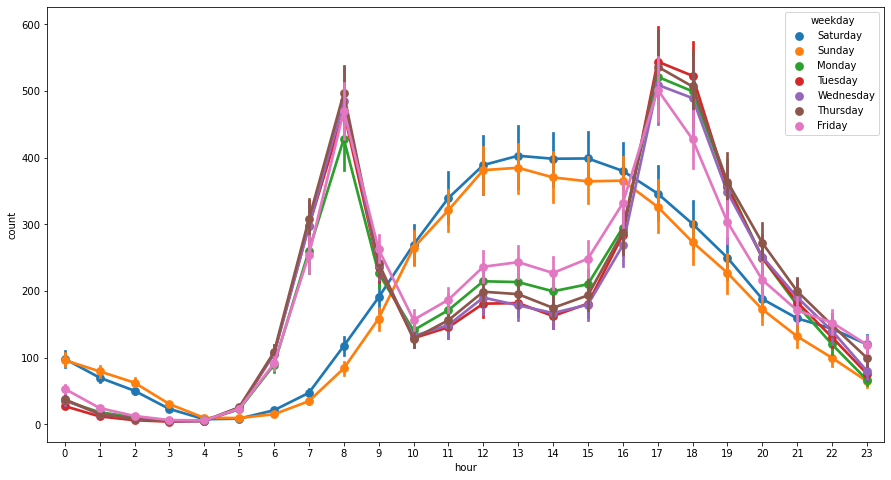

In [29]:
sns.pointplot(x='hour', y='count', data=data_EDA, hue='weekday')

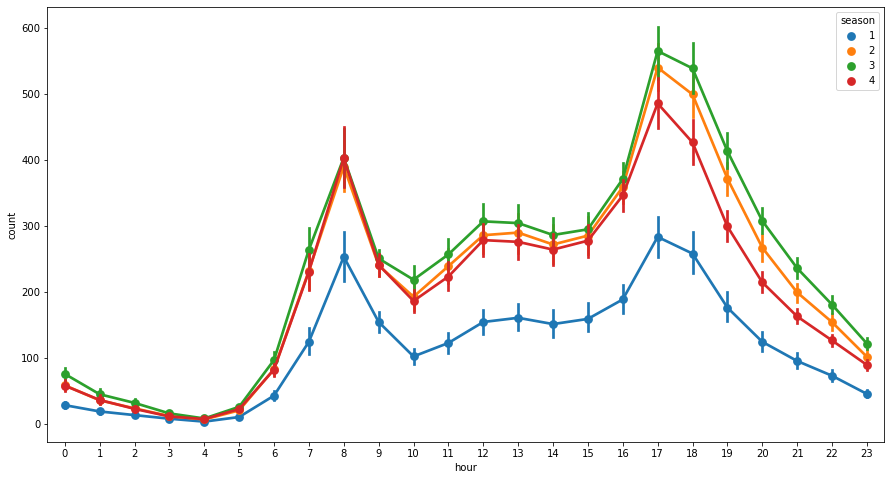

In [30]:
sns.pointplot(x='hour', y='count', data=data_EDA, hue='season')

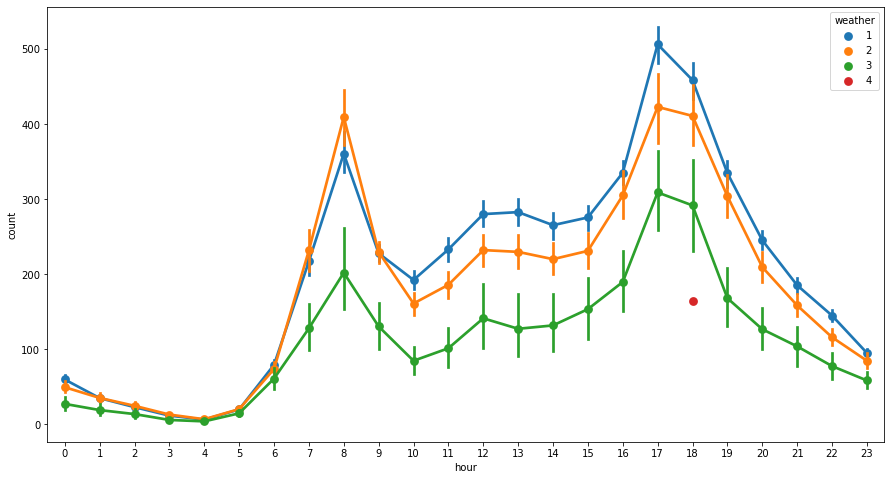

In [31]:
sns.pointplot(x='hour', y='count', data=data_EDA, hue='weather')

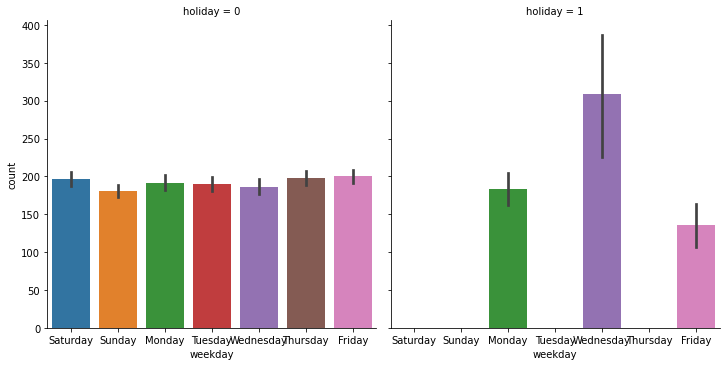

In [32]:
sns.catplot(x='weekday', y='count', data=data_EDA, col='holiday', col_wrap=2, kind='bar')

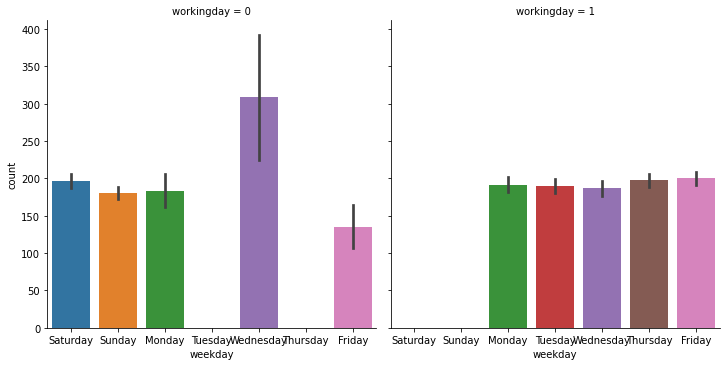

In [33]:
sns.catplot(x='weekday', y='count', data=data_EDA, col='workingday', col_wrap=2, kind='bar')

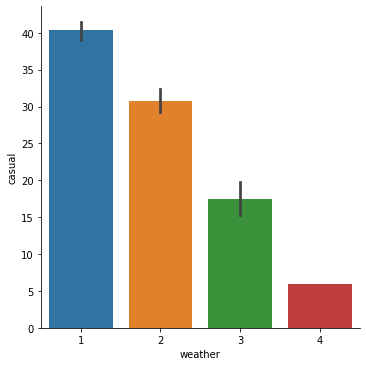

In [34]:
sns.catplot(x='weather', y='casual', data=data_EDA, kind='bar')

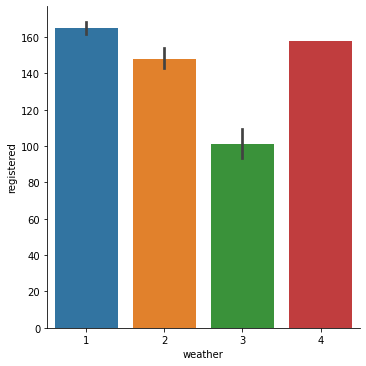

In [35]:
sns.catplot(x='weather', y='registered', data=data_EDA, kind='bar')

In [36]:
data_EDA[data_EDA['weather'] == 4]  ## outlier possibly drop

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,weekday,hour
datetime,,,,,,,,,,,,,,,
2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,1,9,Monday,18


In [37]:
data_EDA['weatherbins'] = pd.cut(data_EDA['windspeed'], bins=3)

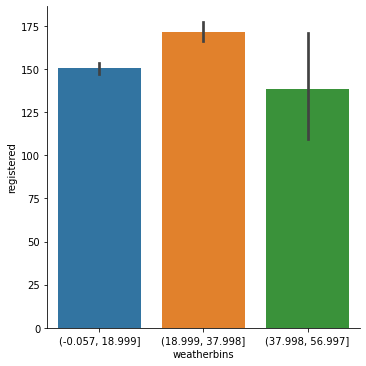

In [38]:
sns.catplot(x='weatherbins', y='registered', data=data_EDA, kind='bar')

Text(0.5, 1.0, 'bike counts vs humidity on daily basis')

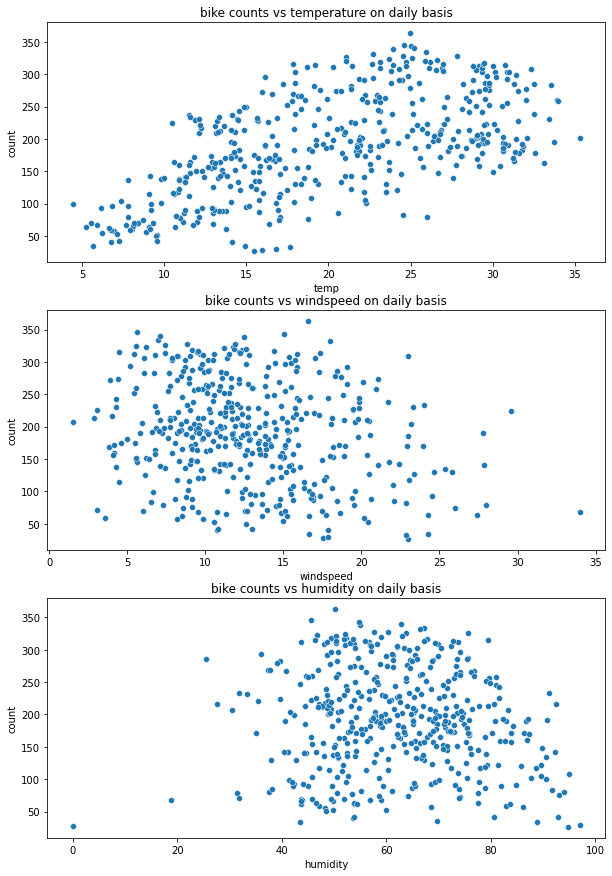

In [39]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharey=True)

sns.scatterplot(ax=ax[0], x='temp', y='count', data=data_EDA.resample('D').mean())
sns.scatterplot(ax=ax[1], x='windspeed', y='count', data=data_EDA.resample('D').mean())
sns.scatterplot(ax=ax[2], x='humidity', y='count', data=data_EDA.resample('D').mean())

ax[0].set_title('bike counts vs temperature on daily basis')
ax[1].set_title('bike counts vs windspeed on daily basis')
ax[2].set_title('bike counts vs humidity on daily basis')

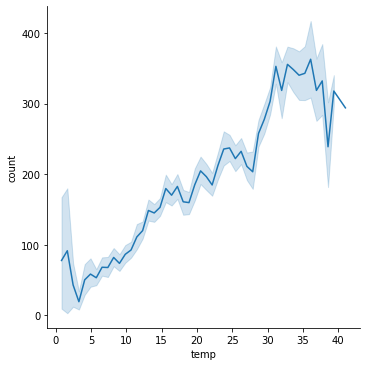

In [40]:
sns.relplot(x='temp', y='count', data=data_EDA, kind='line')

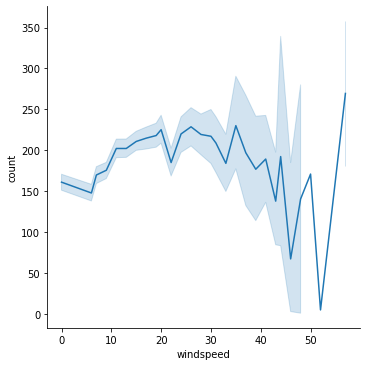

In [41]:
sns.relplot(x='windspeed', y='count', data=data_EDA, kind='line')

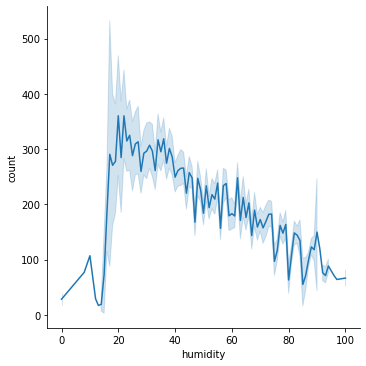

In [42]:
sns.relplot(x='humidity', y='count', data=data_EDA, kind='line')

#### Outlier in humidity broken sensor?

In [43]:
data_EDA[data_EDA['humidity'] < 1].head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,weekday,hour,weatherbins
datetime,,,,,,,,,,,,,,,,
2011-03-10 00:00:00,1,0,1,3,13.94,15.910,0,16.9979,3,0,3,3,10,Thursday,0,"(-0.057, 18.999]"
2011-03-10 01:00:00,1,0,1,3,13.94,15.910,0,16.9979,0,2,2,3,10,Thursday,1,"(-0.057, 18.999]"
2011-03-10 02:00:00,1,0,1,3,13.94,15.910,0,16.9979,0,1,1,3,10,Thursday,2,"(-0.057, 18.999]"
2011-03-10 05:00:00,1,0,1,3,14.76,17.425,0,12.9980,1,2,3,3,10,Thursday,5,"(-0.057, 18.999]"
2011-03-10 06:00:00,1,0,1,3,14.76,16.665,0,22.0028,0,12,12,3,10,Thursday,6,"(18.999, 37.998]"


In [44]:
adj_hum =  data_EDA['humidity'].replace(to_replace=0, value=np.mean([data_EDA.loc['2011-03-09']['humidity'].mean(), data_EDA.loc['2011-03-11']['humidity'].mean()]))

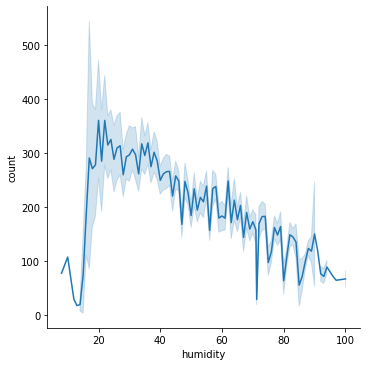

In [45]:
sns.relplot(x=adj_hum, y=data_EDA['count'], kind='line')

In [46]:
data_EDA['humidity'].replace(to_replace=0, 
                               value=np.mean([data_EDA.loc['2011-03-09']['humidity'].mean(), 
                                              data_EDA.loc['2011-03-11']['humidity'].mean()]), 
                               inplace=True)

/Users/marf/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


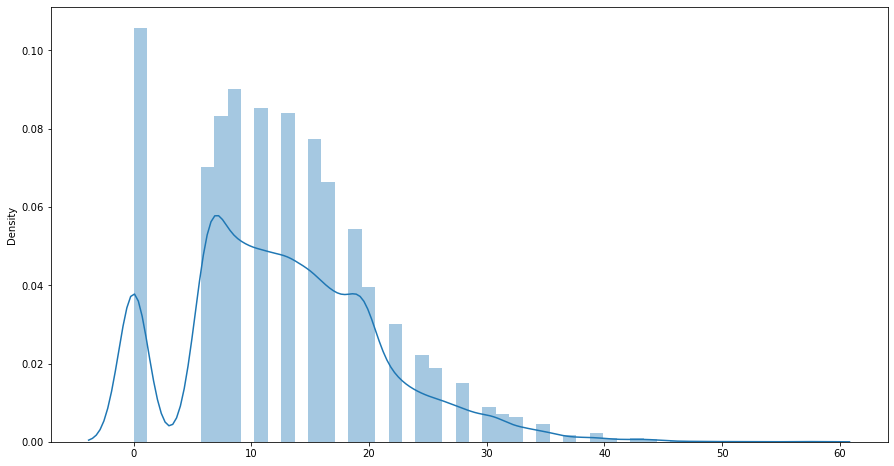

In [47]:
sns.distplot(x=data_EDA['windspeed'])

In [49]:
data_EDA['windbins'] = pd.cut(data_EDA['windspeed'], bins=5)

In [50]:
data_EDA['windbins'].head()

datetime
2011-01-01 00:00:00    (-0.057, 11.399]
2011-01-01 01:00:00    (-0.057, 11.399]
2011-01-01 02:00:00    (-0.057, 11.399]
2011-01-01 03:00:00    (-0.057, 11.399]
2011-01-01 04:00:00    (-0.057, 11.399]
Name: windbins, dtype: category
Categories (5, interval[float64]): [(-0.057, 11.399] < (11.399, 22.799] < (22.799, 34.198] < (34.198, 45.598] < (45.598, 56.997]]

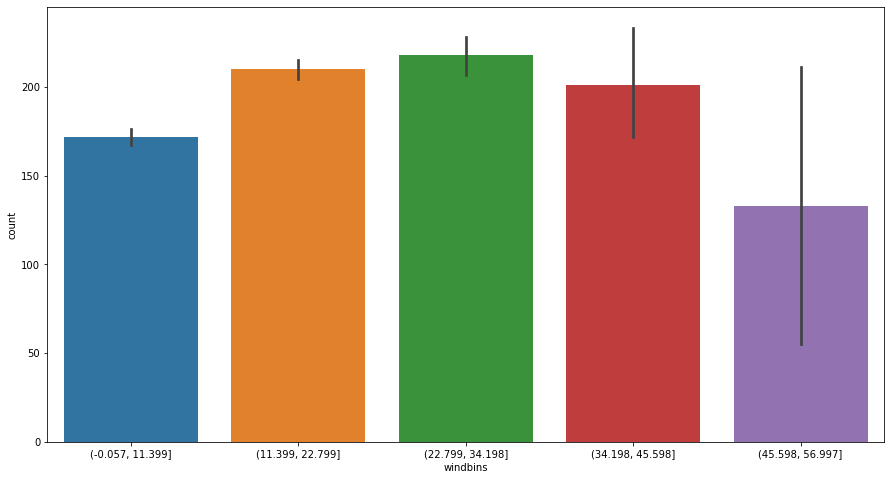

In [51]:
sns.barplot(x='windbins', y='count', data=data_EDA)

In [53]:
wind_no_outlier = data_EDA.drop(detect_outlier(data_EDA['windspeed']).index)

In [54]:
wind_no_outlier['windbins'] = pd.cut(wind_no_outlier['windspeed'], bins=5)

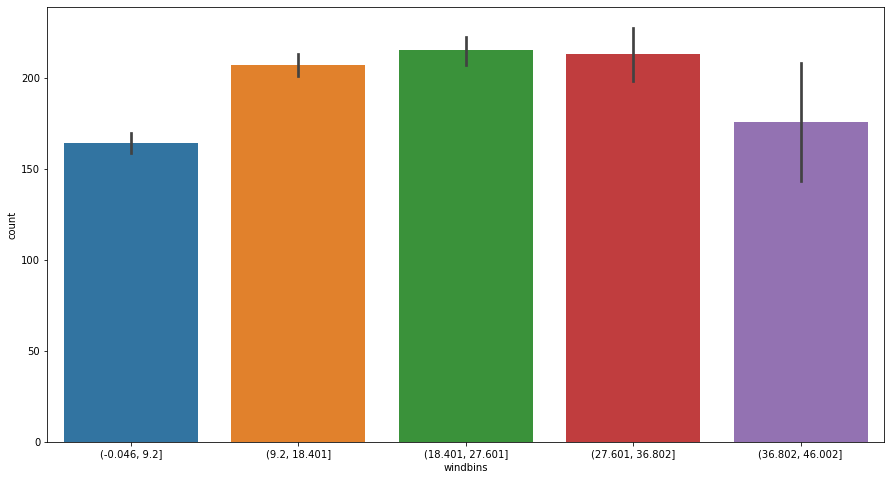

In [55]:
sns.barplot(x='windbins', y='count', data=wind_no_outlier)

/Users/marf/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


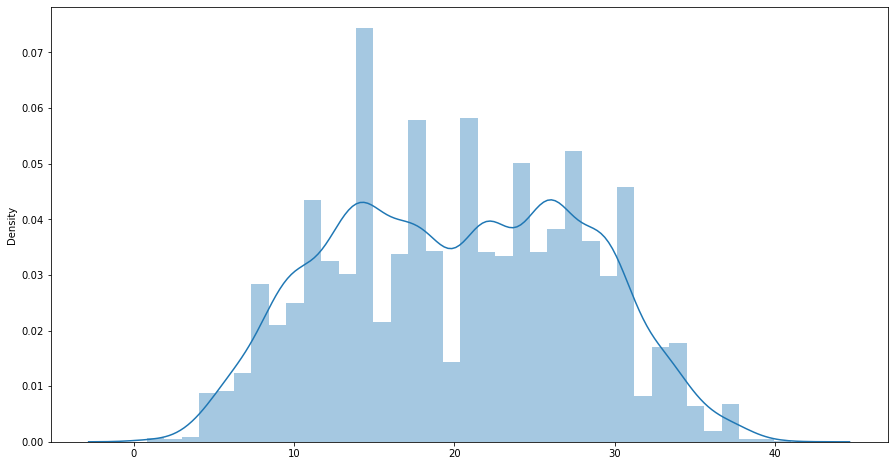

In [56]:
sns.distplot(x=data_EDA['temp'])

In [57]:
data_EDA['tempbins'] = pd.cut(data_EDA['temp'], bins=10)

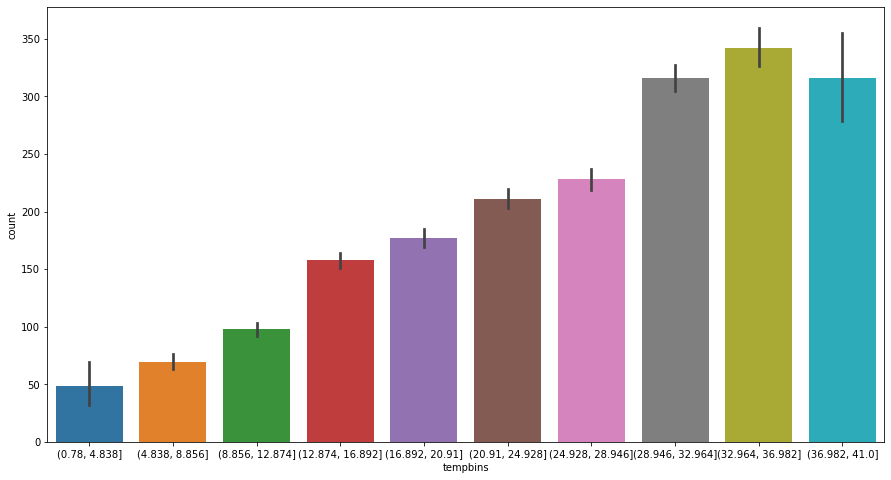

In [58]:
sns.barplot(x='tempbins', y='count', data=data_EDA)

In [59]:
data_EDA[data_EDA['temp'] > 37]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,weekday,hour,weatherbins,windbins,tempbins
datetime,,,,,,,,,,,,,,,,,,
2011-06-08 14:00:00,2,0,1,1,37.72,43.940,40.0,16.9979,44,111,155,6,8,Wednesday,14,"(-0.057, 18.999]","(11.399, 22.799]","(36.982, 41.0]"
2011-06-08 15:00:00,2,0,1,1,37.72,43.940,40.0,11.0014,28,100,128,6,8,Wednesday,15,"(-0.057, 18.999]","(-0.057, 11.399]","(36.982, 41.0]"
2011-06-08 16:00:00,2,0,1,1,37.72,43.940,40.0,15.0013,34,199,233,6,8,Wednesday,16,"(-0.057, 18.999]","(11.399, 22.799]","(36.982, 41.0]"
2011-06-08 17:00:00,2,0,1,1,37.72,42.425,35.0,15.0013,80,426,506,6,8,Wednesday,17,"(-0.057, 18.999]","(11.399, 22.799]","(36.982, 41.0]"
2011-06-09 12:00:00,2,0,1,1,37.72,42.425,35.0,12.9980,40,100,140,6,9,Thursday,12,"(-0.057, 18.999]","(11.399, 22.799]","(36.982, 41.0]"
2011-06-09 14:00:00,2,0,1,1,37.72,43.940,40.0,12.9980,25,93,118,6,9,Thursday,14,"(-0.057, 18.999]","(11.399, 22.799]","(36.982, 41.0]"
2011-06-09 15:00:00,2,0,1,1,38.54,41.665,31.0,11.0014,18,86,104,6,9,Thursday,15,"(-0.057, 18.999]","(-0.057, 11.399]","(36.982, 41.0]"
2011-06-09 16:00:00,2,0,1,1,37.72,41.665,33.0,8.9981,30,170,200,6,9,Thursday,16,"(-0.057, 18.999]","(-0.057, 11.399]","(36.982, 41.0]"
2011-08-01 14:00:00,3,0,1,1,37.72,40.910,29.0,12.9980,37,86,123,8,1,Monday,14,"(-0.057, 18.999]","(11.399, 22.799]","(36.982, 41.0]"


In [60]:
data_EDA['humiditybins'] = pd.cut(data_EDA['humidity'], bins=5)

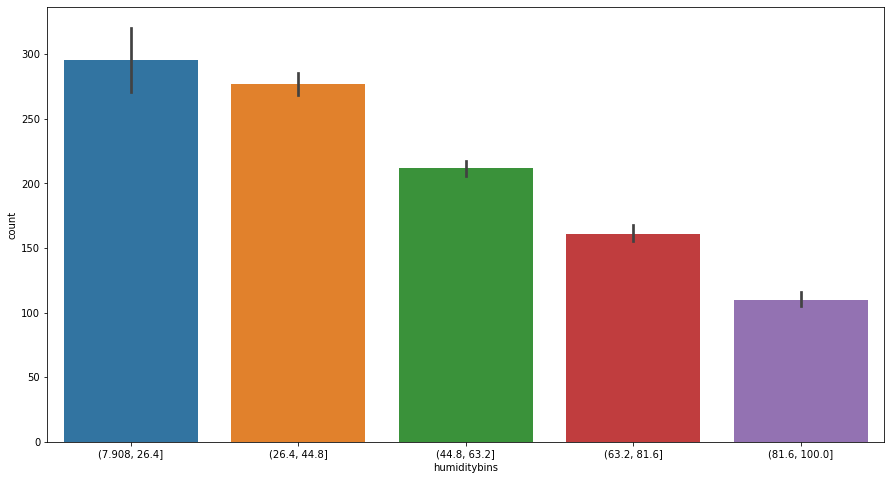

In [61]:
sns.barplot(x='humiditybins', y='count', data=data_EDA)

## Benchmark Model

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, r2_score

In [63]:
X_train = data.drop(['count', 'casual', 'registered'], axis=1)
y_train = data['count']

### Linear Regression

In [64]:
lr_base = LinearRegression().fit(X_train, np.log1p(y_train))

print("Coefficients:", lr_base.coef_)
print("Intercept   :", lr_base.intercept_)

print("train score :", lr_base.score(X_train, y_train))

Coefficients: [ 0.18938095 -0.0963132  -0.09554135  0.11743638  0.00536533  0.04939067
 -0.02599913  0.00868621]
Intercept   : 4.238817170425407
train score : -1.061526135739463


In [65]:
r2_score(np.log1p(y_train), lr_base.predict(X_train))

0.2631307919974998

In [66]:
np.sqrt(mean_squared_log_error(y_train, np.expm1(lr_base.predict(X_train))))

1.218418923548012

### Random Forest

In [67]:
rdf_base = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=5, min_samples_leaf=1)

In [68]:
rdf_base.fit(X_train, np.log1p(y_train))

RandomForestRegressor(max_depth=5, min_samples_split=5)

In [69]:
r2_score(np.log1p(y_train), rdf_base.predict(X_train))

0.31214204565093495

In [70]:
np.sqrt(mean_squared_log_error(y_train, np.expm1(rdf_base.predict(X_train))))

1.1772015168360288

## Feature Engineering

In [71]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, StandardScaler, MinMaxScaler 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [72]:
data_feat = data.copy()

In [73]:
extract_date_info(data_feat)

In [74]:
data_feat.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,weekday,hour
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,Saturday,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,Saturday,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,Saturday,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,1,Saturday,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,1,Saturday,4


### Remove outliers

In [75]:
data_feat.drop(detect_outlier(data_feat['count']).index, inplace=True) # y-data (count) outlier

In [76]:
data_feat.drop(detect_outlier(data_feat['windspeed']).index, inplace=True) ## windspeed outlier

In [77]:
# drop outlier weather data point of category 4
#data_feat.drop(data_feat[data_feat['weather'] == 4].index, inplace=True) 

### Fill missing values

In [78]:
data_feat['humidity'].replace(to_replace=0, 
                               value=np.mean([data_feat.loc['2011-03-09']['humidity'].mean(), 
                                              data_feat.loc['2011-03-11']['humidity'].mean()]), 
                               inplace=True)

### Split X and Y

In [79]:
y_train_feat = data_feat['count']
X_train_feat = data_feat.drop(['count', 'casual', 'registered'], axis=1)

### Transform y

In [80]:
y_train_feat_log = np.log1p(y_train_feat)

In [81]:
#X_train['hr_sin'] = np.sin(X_train.index.hour*(2.*np.pi/24))
#X_train['hr_cos'] = np.cos(X_train.index.hour*(2.*np.pi/24))
#X_train['mnth_sin'] = np.sin((X_train.month-1)*(2.*np.pi/12))
#X_train['mnth_cos'] = np.cos((X_train.month-1)*(2.*np.pi/12))
#X_train['wkd_sin'] = np.sin((X_train.index.weekday)*(2.*np.pi/7))
#X_train['wkd_cos'] = np.cos((X_train.index.weekday)*(2.*np.pi/7))

In [82]:
pipeline_bin5_scale = Pipeline(steps=[('bin5', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')), ('scale', MinMaxScaler())])
pipeline_bin10_scale = Pipeline(steps=[('bin5', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')), ('scale', MinMaxScaler())])

In [83]:
feature_eng = ColumnTransformer([
    ('pass', 'passthrough', ['windspeed', 'humidity', 'temp']),
    ('encode', OneHotEncoder(drop='first'), ['hour', 'month', 'weekday', 'weather']),
    #('bins_5 and scale', pipeline_bin5_scale, ['windspeed', 'humidity']),
    #('bins_10 and scale', pipeline_bin10_scale, ['temp']),
    #('scale and standarise', pipeline_scale_std , ['windspeed', 'humidity', 'temp'])
]) 

In [84]:
feature_eng_matrix = feature_eng.fit_transform(X_train_feat)

In [85]:
#y_train.reset_index(drop=True, inplace=True)

## Train Model

### Linear Regression

In [86]:
lr = LinearRegression().fit(feature_eng_matrix, y_train_feat_log)

print("Coefficients:", lr.coef_)
print("Intercept   :", lr.intercept_)

print("train score :", lr.score(feature_eng_matrix, y_train_feat_log))

Coefficients: [-0.00524678 -0.00557843  0.03897175 -0.5987423  -1.08715889 -1.5705399
 -1.82892152 -0.87310382  0.30716514  1.26902224  1.88342552  1.53656382
  1.19084764  1.2892674   1.45865922  1.42063235  1.33038452  1.38655317
  1.65169759  2.06041524  1.99054476  1.72448162  1.43854808  1.19270451
  0.96140361  0.57484171  0.14105407  0.19579824  0.35805968  0.55841378
  0.43161698  0.28821248  0.32931089  0.48759975  0.6577553   0.66833429
  0.65085125 -0.1395033   0.01384969 -0.07118742 -0.08237785 -0.15591781
 -0.14070637 -0.01778824 -0.48047216  0.2951961 ]
Intercept   : 3.1513817162943836
train score : 0.8062199085333888


In [87]:
np.sqrt(mean_squared_log_error(y_train_feat, np.expm1(lr.predict(feature_eng_matrix))))

0.6238963988386417

### Random Forest

In [109]:
rdf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=1)

In [110]:
rdf.fit(feature_eng_matrix, y_train_feat_log)

RandomForestRegressor(max_depth=10, min_samples_split=5)

In [111]:
r2_score(np.log1p(y_train_feat), np.expm1(rdf.predict(feature_eng_matrix)))

-18223.434548619432

In [112]:
np.sqrt(mean_squared_log_error(y_train_feat, np.expm1(rdf.predict(feature_eng_matrix))))

0.6196678653783889

## Optimize Hyperparameters / Cross-Validation

In [92]:
from sklearn.model_selection import cross_val_score, StratifiedKFold 
from sklearn.metrics import make_scorer

In [93]:
def rsmle_scorer(y_true, y_pred):
    RSMLE = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
    return RSMLE

In [94]:
cross_val_score(estimator=lr, 
                X=feature_eng_matrix, 
                y=y_train_feat,
                scoring= make_scorer(rsmle_scorer, greater_is_better=True),
                cv=5)

<ipython-input-93-4c4d5c0a3a1a>:2: RuntimeWarning: invalid value encountered in log1p
  RSMLE = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
<ipython-input-93-4c4d5c0a3a1a>:2: RuntimeWarning: invalid value encountered in log1p
  RSMLE = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
<ipython-input-93-4c4d5c0a3a1a>:2: RuntimeWarning: invalid value encountered in log1p
  RSMLE = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
<ipython-input-93-4c4d5c0a3a1a>:2: RuntimeWarning: invalid value encountered in log1p
  RSMLE = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
<ipython-input-93-4c4d5c0a3a1a>:2: RuntimeWarning: invalid value encountered in log1p
  RSMLE = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))


array([1.08552459, 1.11761878, 0.95057286, 0.72626147, 0.74221821])

## Calculate test score = Submission to Kaggle

In [95]:
test = pd.read_csv('data/bike-share-demand/test.csv', parse_dates=True, index_col=0)

In [96]:
extract_date_info(test)

In [97]:
test_matrix = feature_eng.transform(test)

In [98]:
y_test = lr.predict(test_matrix)

In [99]:
y_test_df = pd.DataFrame(np.expm1(y_test), index=test.index, columns=['count'])

In [100]:
y_test_df.to_csv('data/bike-share-demand/prediction_rdf.csv')